<a href="https://colab.research.google.com/github/ander002/DeepLearning/blob/main/DeepLearning_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#更深的网络----ResNet

## ResNet要解决的问题
> &emsp;&emsp;退化问题：随着层数加深到一定程度后，越深的网络反而效果越差，并且并不是因为更深的网络造成了过拟合，也未必是因为梯度传播的衰减，因为已经有很多行之有效的方法来避免这个问题。

> &emsp;&emsp;在深度达到一定程度的时候,weight和bias都接近0,此时某一深层的output几乎为0,这样当bp的时候,很难更新weight和bias,不利于学习,但是通过残差块,这一层output+前一层的input作为下一层的input,这样通往下一层的weight和bias不至于为0,使得bp继续进行下去,继续更新weight和bias.(个人理解,不对请指出),貌似这是梯度消失,通过BN可以解决.
![例子](http://pan.anderd.com/download/6156d12aa126c5003fc5a55e)

## 先备知识

> 残差：是指预测值和观测值之间的差异，注意与误差的区别，误差是指观测值和真实值之间的差异。

## 残差块
![ResBlock](http://pan.anderd.com/download/6156d503302257003f390e35)

> &emsp;&emsp;如图假设我们的原始输⼊为x，而希望学出的理想映射为f(x)（作为上⽅激活函数的输⼊）。左图虚线框中的部分需要直接拟合出该映射f(x)，而右图虚线框中的部分则需要拟合出残差映射f(x)−x。残差映射在现实中往往更容易优化。ResNe模型中大量使用了一些相同的模块来搭建更深的网络，最后得到的模型在性能上却有不俗的表现，其中一个非常关键的因素就是模型累加的模块并非简单的单输入单输出的结构，而是一种设置了附加关系的新结构，这个附加关系就是恒等映射（Identit Mapping），这个新结构就是残差网络结构.

> &emsp;&emsp;事实证明，残差模块进行的这个简单的加法并不会给整个ResNet模型增加额外的参数和计算量.却能加快模型的训练速度，提升模型的训练效果;另外，在我们搭建的ResNet模型的深度加深时，使用残差模块的网络结构不仅不会出现模型退化问题,性能反而有所提升.

> &emsp;&emsp;这里需要注意附加的恒等映射关系的两种不同的使用情况，残差模块的输入数据若和输出结果的维度一致，则直接相加；若维度不一致，则先进行线性投影，在得到一致的维度后，再进行相加或者对维度不一致的部分使用0填充.

In [1]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.3 MB/s 


In [ ]:
#残差块的实现,首先ResNet沿用了VGG的完整的3x3卷积层设计.残差块里首先有两个相同输出通道的3x3卷积层,每个卷积层后接⼀个批量归⼀化层和ReLU激活函数。

import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
  def __init__(self,input_channels,num_channels,use_1x1conv=False,strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1,stride=strides)#输入输出形状不变的卷积层
    self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)
    self.relu = nn.ReLU(inplace=True)

  def forward(self,X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)
# 此代码⽣成两种类型的⽹络：
#⼀种是在use_1x1conv=False、应⽤ReLU⾮线性函数之前，将输⼊添加到输出。
#另⼀种是在use_1x1conv=True时，添加通过1×1卷积调整通道和分辨率。


![两种网络](http://pan.anderd.com/download/6156ea8d9ca0c6003f2d0212)

In [ ]:
#输入和输出形状一样的情况
blk = Residual(3,3)
X = torch.rand(4,3,6,6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [ ]:
#我们可以增加输出通道的同时减版输出的高宽
blk = Residual(3,6,use_1x1conv=True,strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## ResNet模型


In [ ]:
#前两层与GooLeNet中的一样,不同之处在于ResNet每个卷积层后加了BN
b1 = nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

&emsp;&emsp;ResNet使⽤4个由残差块组成的模块，每个模块使⽤若干个同样输出通道数的残差块。第⼀个模块的通道数同输⼊通道数⼀致。由于之前已经使⽤了步幅为2的最⼤汇聚层，所以⽆须减小⾼和宽。之后的每个模块在第⼀个残差块⾥将上⼀个模块的通道数翻倍，并将⾼和宽减半。

In [ ]:
def resnet_block(input_channles,num_channles,num_residuals,first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channles,num_channles,use_1x1conv=True,strides=2))
    else:
      blk.append(Residual(num_channles,num_channles))
  return blk

In [ ]:
#接着在ResNet加⼊所有残差块，这⾥每个模块使⽤2个残差块。
b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True))
b3 = nn.Sequential(*resnet_block(64,128,2))
b4 = nn.Sequential(*resnet_block(128,256,2))
b5 = nn.Sequential(*resnet_block(256,512,2))

In [ ]:
#最后与GooLeNet一样,加入全局平均汇聚层,以及全连接层输出
net = nn.Sequential(b1,b2,b3,b4,b5,nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),nn.Linear(512,10))

&emsp;&emsp;每个模块有4个卷积层（不包括恒等映射的1×1卷积层）。加上第⼀个7×7卷积层和最后⼀个全连接层，共有18层。因此，这种模型通常被称为ResNet-18。通过配置不同的通道数和模块⾥的残差块数可以得到不同的ResNet模型.
![ResNet-18](http://pan.anderd.com/download/6156f11edfbe2a003f06123e)

In [ ]:
#同样我们来看看每一层形状
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 0.011, train acc 0.997, test acc 0.901
374.3 examples/sec on cuda:0


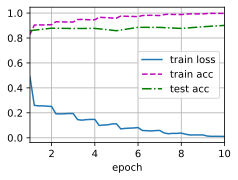

In [ ]:
#训练模型
lr,num_epochs,batch_size = 0.05,10,256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size,resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

#DenseNet（稠密链接网络）
&emsp;&emsp;ResNet 将f分解为两部分：⼀个简单的线性项和⼀个更复杂的⾮线性项。那么再向前拓展⼀步，如果我们想将f拓展成超过两部分的信息呢,⼀种⽅案便是DenseNet。

![DenseNet1](http://pan.anderd.com/download/6157ba517c63dc003fe56437)

 ResNet（左）与 DenseNet（右）在跨层连接上的主要区别：使⽤相加和使⽤连结。
![DenseConnection](http://pan.anderd.com/download/6157c295c374ce003f76095d)

&emsp;&emsp;稠密⽹络主要由2部分构成：稠密块（dense block）和过渡层（transition layer）。前者定义如何连接输⼊和输出，而后者则控制通道数量，使其不会太复杂。

In [2]:
#稠密块

import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels,num_channels):
  return nn.Sequential(
      nn.BatchNorm2d(input_channels),nn.ReLU(),
      nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1))
#⼀个稠密块由多个卷积块组成，每个卷积块使⽤相同数量的输出信道。然而，在前向传播中，我们将每个卷积块的输⼊和输出在通道维上连结。

In [3]:
class DenseBlock(nn.Module):
  def __init__(self,num_convs,input_channels,num_channels):
    super().__init__()
    layer = []
    for i in range(num_convs):
      layer.append(conv_block(num_channels * i + input_channels,num_channels))
    self.net = nn.Sequential(*layer)
  def forward(self,X):
    for blk in self.net:
      Y = blk(X)
      X = torch.cat((X,Y),dim=1)#连接通道维度上每个块的输⼊和输出
    return X

In [4]:
blk = DenseBlock(2,3,10)
X = torch.randn(4,3,8,8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [5]:
#过渡层，由于每个稠密块都会带来通道数的增加，使⽤过多则会过于复杂化模型。而过渡层可以⽤来控制模型复杂度。
#它通过1×1卷积层来减小通道数，并使⽤步幅为2的平均汇聚层减半⾼和宽，从而进⼀步降低模型复杂度。
def transition_block(input_channels,num_channels):
  return nn.Sequential(
      nn.BatchNorm2d(input_channels),nn.ReLU(),
      nn.Conv2d(input_channels,num_channels,kernel_size=1),
      nn.AvgPool2d(kernel_size=2,stride=2))

In [6]:
blk = transition_block(23,10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [7]:
#DenseNet模型
b1 = nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1))#DenseNet ⾸先使⽤同 ResNet ⼀样的单卷积层和最⼤汇聚层。

In [8]:
num_channels,growth_rate = 64,32
num_convs_in_dense_blocks = [4,4,4,4]
blks = []
for i,num_convs in enumerate(num_convs_in_dense_blocks):
  blks.append(DenseBlock(num_convs,num_channels,growth_rate))
  #上一层周密块的输出通道
  num_channels += num_convs * growth_rate
  #在稠密块之间添加⼀个转换层，使通道数量减半
  if i != len(num_convs_in_dense_blocks)-1:
    blks.append(transition_block(num_channels,num_channels // 2))
    num_channels = num_channels // 2

net = nn.Sequential(
    b1,*blks,
    nn.BatchNorm2d(num_channels),nn.ReLU(),
    nn.AdaptiveAvgPool2d((1,1)),#与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。
    nn.Flatten(),
    nn.Linear(num_channels,10))

loss 0.144, train acc 0.947, test acc 0.898
949.8 examples/sec on cuda:0


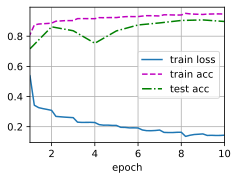

In [9]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

##小结
* 在跨层连接上，不同于ResNet中将输⼊与输出相加，稠密连接⽹络（DenseNet）在通道维上连结输⼊与输出。
* DenseNet的主要构建模块是稠密块和过渡层。
* 在构建DenseNet时，我们需要通过添加过渡层来控制⽹络的维数，从而再次减少信道的数量。